# Holland 2008 model

In [2]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sithom.plot import plot_defaults, label_subplots
from sithom.time import timeit
from src.conversions import si_ify, knots_to_ms
from src.data_loading.ibtracs import kat_stats

In [9]:
kat_stats()

/Users/simon/new-orleans/env/lib/python3.8/site-packages/xarray/backends/plugins.py:64: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:      (storm: 1, quadrant: 4)
Coordinates:
    time         (storm) datetime64[ns] ...
    lat          (storm) float32 ...
    lon          (storm) float32 ...
Dimensions without coordinates: storm, quadrant
Data variables: (12/16)
    nature       (storm) |S2 b'TS'
    basin        (storm) |S2 b'NA'
    subbasin     (storm) |S2 b'GM'
    name         (storm) |S128 b'KATRINA'
    storm_speed  (storm) float32 7.717
    storm_dir    (storm) float32 ...
    ...           ...
    usa_poci     (storm) float32 1.005e+05
    usa_lat      (storm) float32 ...
    usa_r34      (storm, quadrant) float32 2.852e+05 3.519e+05 ... 1.852e+05
    usa_r50      (storm, quadrant) float32 1.833e+05 2.037e+05 ... 1.389e+05
    usa_r64      (storm, quadrant) float32 1.315e+05 1.315e+05 ... 8.519e+04
    usa_record   (storm) |S1 b'L'
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [10]:
ds = kat_stats()

In [11]:
ds["usa_r64"]

<xarray.DataArray 'usa_r64' (storm: 1, quadrant: 4)>
array([[131492., 131492.,  85192.,  85192.]], dtype=float32)
Coordinates:
    time     (storm) datetime64[ns] ...
    lat      (storm) float32 ...
    lon      (storm) float32 ...
Dimensions without coordinates: storm, quadrant
Attributes:
    long_name:              Radius of 64 knot winds
    units:                  m
    valid_min:              1
    valid_max:              1000
    coverage_content_type:  physicalMeasurement

In [25]:
r64 = ds["usa_r64"].values.mean()
v64 = knots_to_ms(64)

In [38]:
rmax = ds["usa_rmw"].values
vmax = ds["usa_wind"].values

In [48]:
vmax

array([54.01667], dtype=float32)

In [49]:
rmax

array([40744.], dtype=float32)

In [69]:
radii = np.linspace(0, 1e6, num=int(1e4))

xn=0.6
hx(radii, rmax, xn, r64)

array([0.5, 0.5, 0.5, ..., 0.6, 0.6, 0.6])

In [30]:
ds

<xarray.Dataset>
Dimensions:      (storm: 1, quadrant: 4)
Coordinates:
    time         (storm) datetime64[ns] 2005-08-29T14:45:00.000053248
    lat          (storm) float32 30.2
    lon          (storm) float32 -89.6
Dimensions without coordinates: storm, quadrant
Data variables: (12/16)
    nature       (storm) |S2 b'TS'
    basin        (storm) |S2 b'NA'
    subbasin     (storm) |S2 b'GM'
    name         (storm) |S128 b'KATRINA'
    storm_speed  (storm) float32 7.717
    storm_dir    (storm) float32 ...
    ...           ...
    usa_poci     (storm) float32 1.005e+05
    usa_lat      (storm) float32 ...
    usa_r34      (storm, quadrant) float32 2.852e+05 3.519e+05 ... 1.852e+05
    usa_r50      (storm, quadrant) float32 1.833e+05 2.037e+05 ... 1.389e+05
    usa_r64      (storm, quadrant) float32 1.315e+05 1.315e+05 ... 8.519e+04
    usa_record   (storm) |S1 b'L'
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [113]:
pc = ds["usa_pres"].values
pn = ds["usa_poci"].values

In [114]:
@np.vectorize
def hx(radius: float, rmax: float, xn: float, rn: float) -> float:
    """"""
    if radius <= rmax:
        return 0.5
    else:
        return 0.5 + (radius - rmax) * (xn - 0.5) / (radius - rmax)


def h08(
    radius: float,
    rmax: float,
    vmax: float,
    pc: float,
    pn: float,
    r64: float,
    xn: float,
    density: float = 1.15,
) -> float:
    """Hurricane 2008."""
    b = vmax**2 * np.e * density / (pn - pc)
    x = hx(radius, rmax, xn, r64)
    return vmax * ((rmax / radius) ** b * np.exp(1 - (rmax / radius) ** b)) ** x

In [115]:
plot_defaults()

Text(0.5, 0, 'Distance [m]')

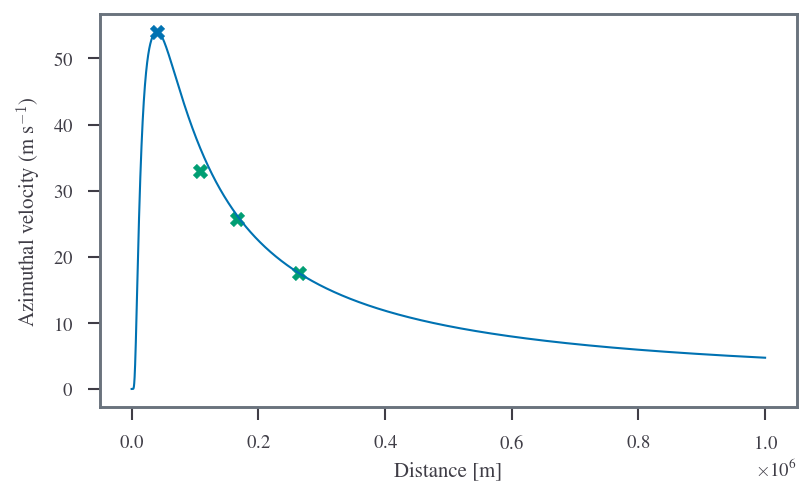

In [130]:
radii = np.linspace(1, 1e6, num=int(1e4))
# velocities = h08(radii, rmax, vmax, millibar_to_pascal(pc), millibar_to_pascal(pn), r64, 0.5, density=1.05)
velocities = h08(radii, rmax, vmax, pc, pn, r64, 0.99, density=1.04)
plt.plot(radii, velocities)
speeds = knots_to_ms([64, 50, 34])
distances = [ds[x].values.mean() for x in ["usa_r64", "usa_r50", "usa_r34"]]
plt.scatter(rmax, vmax)
plt.scatter(distances, speeds)
plt.ylabel("Azimuthal velocity (m s$^{-1}$)")
plt.xlabel("Distance [m]")

In [58]:
speeds = knots_to_ms([64, 50, 34])

In [61]:
[ds[x].values.mean() for x in ["usa_r64", "usa_r50", "usa_r34"]]

[108342.0, 166217.0, 264373.0]

In [56]:
ds

<xarray.Dataset>
Dimensions:      (storm: 1, quadrant: 4)
Coordinates:
    time         (storm) datetime64[ns] 2005-08-29T14:45:00.000053248
    lat          (storm) float32 30.2
    lon          (storm) float32 -89.6
Dimensions without coordinates: storm, quadrant
Data variables: (12/16)
    nature       (storm) |S2 b'TS'
    basin        (storm) |S2 b'NA'
    subbasin     (storm) |S2 b'GM'
    name         (storm) |S128 b'KATRINA'
    storm_speed  (storm) float32 7.717
    storm_dir    (storm) float32 0.0
    ...           ...
    usa_poci     (storm) float32 1.005e+05
    usa_lat      (storm) float32 30.2
    usa_r34      (storm, quadrant) float32 2.852e+05 3.519e+05 ... 1.852e+05
    usa_r50      (storm, quadrant) float32 1.833e+05 2.037e+05 ... 1.389e+05
    usa_r64      (storm, quadrant) float32 1.315e+05 1.315e+05 ... 8.519e+04
    usa_record   (storm) |S1 b'L'
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [148]:
def h08_fitfunc(rmax, vmax, pc, pn, r64, density=1.04):
    def v_func(radius, xn):
        return h08(radius, rmax, vmax, pc, pn, r64, xn, density=density)

    return v_func

In [149]:
h08_fitfunc(rmax, vmax, pc, pn, r64, density=1.04)(radii, 1)

array([0.00000000e+000, 1.07397440e-131, 8.38891002e-062, ...,
       4.61158046e+000, 4.61110237e+000, 4.61062438e+000])

In [134]:
from scipy.optimize import curve_fit

In [142]:
np.array(distances)

array([108342., 166217., 264373.], dtype=float32)

In [143]:
speeds

array([32.92444444, 25.72222222, 17.49111111])

In [194]:
from typing import Callable, Union, Tuple
from typeguard import typechecked


@typechecked
def h08_fitfunc(
    rmax: float, vmax: float, pc: float, pn: float, r64: float, density: float = 1.04
) -> Callable:
    def v_func(radius: float, xn: float) -> float:
        return h08(radius, rmax, vmax, pc, pn, r64, xn, density=density)

    return v_func


@typechecked
def fit_h08(
    rmax: float,
    vmax: float,
    pc: float,
    pn: float,
    r64: float,
    distances: Union[list, np.ndarray],
    speeds: Union[list, np.ndarray],
    density: float = 1.04,
) -> Tuple[Callable, float]:

    h08v = h08_fitfunc(rmax, vmax, pc, pn, r64, density=density)
    popt, perr = curve_fit(h08v, distances, speeds, p0=[1])

    def vel_f(xn) -> Callable:
        def vel(radius):
            return h08v(radius, xn)

        return vel

    return vel_f(popt), float(popt)

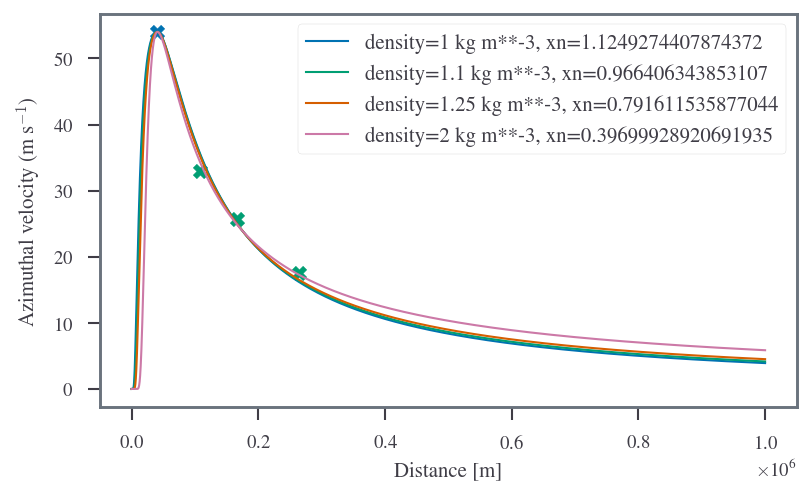

In [195]:
radii = np.linspace(1, 1e6, num=int(1e4))
for density in [1, 1.1, 1.25, 2]:
    h08v_fit, xn = fit_h08(
        float(rmax),
        float(vmax),
        float(pc),
        float(pn),
        float(r64),
        distances,
        speeds,
        density=density,
    )
    velocities = h08v_fit(radii)
    plt.plot(radii, velocities, label=f"density={density} kg m**-3, xn={xn}")
speeds = knots_to_ms([64, 50, 34])
distances = [ds[x].values.mean() for x in ["usa_r64", "usa_r50", "usa_r34"]]
plt.scatter(rmax, vmax)
plt.scatter(distances, speeds)
plt.ylabel("Azimuthal velocity (m s$^{-1}$)")
plt.xlabel("Distance [m]")
plt.legend()